In [1]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as td
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors

froot = './data/k562_1300'

df = pd.read_csv(froot + ".csv")

In [2]:
print(df.head())

   seqnames     start       end strand  ensembl_gene_id  score      ctcf  \
0         6  41077441  41077441      +  ENSG00000001167    0.0 -0.074159   
1         6  41077442  41077442      +  ENSG00000001167    0.0 -0.074217   
2         6  41077443  41077443      +  ENSG00000001167    0.0 -0.074276   
3         6  41077444  41077444      +  ENSG00000001167    0.0 -0.074336   
4         6  41077445  41077445      +  ENSG00000001167    0.0 -0.074398   

   h3k36me3   h3k4me1  h3k79me2  ...       sj3       dms      rpts  wgbs  \
0 -0.347414 -0.231637  1.630302  ... -0.057178 -0.307549  0.249626   0.0   
1 -0.346807 -0.231970  1.628545  ... -0.057178 -0.307549  0.249626   0.0   
2 -0.346199 -0.232304  1.626748  ... -0.057178 -0.307549  0.249626   0.0   
3 -0.345591 -0.232638  1.624913  ... -0.057178 -0.307549  0.249626   0.0   
4 -0.344983 -0.232972  1.623041  ... -0.057178 -0.307549  0.249626   0.0   

       A         T         G         C  lambda_alphaj      zeta  
0 -0.625  1.473964 -

In [3]:
df['gene_length'] = df.groupby('ensembl_gene_id')['ensembl_gene_id'].transform('count')

In [4]:
column_names = df.columns.tolist()
feature_names = column_names[6:-7]
nucleotides = column_names[-7:-3]
print(feature_names)
print(nucleotides)

# process read counts
X_ji = df.groupby('ensembl_gene_id')['score'].apply(list).tolist() 

# process GLM simulated elongation rates
Z_ji = df.groupby('ensembl_gene_id')['zeta'].apply(list).tolist() 

num_samples = len(X_ji)

['ctcf', 'h3k36me3', 'h3k4me1', 'h3k79me2', 'h3k9me1', 'h3k9me3', 'h4k20me1', 'sj5', 'sj3', 'dms', 'rpts', 'wgbs']
['A', 'T', 'G', 'C']


In [5]:
print(num_samples)

1502


In [87]:
from sklearn.preprocessing import MinMaxScaler

#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   [[sample_1_feature_1], [sample_1_feature_2], [sample_1_feature_3]],
    #   [[sample_2_feature_1], [sample_2_feature_2], [sample_2_feature_3]],  
    # ]

Y_ji = []

for sample_id in df['ensembl_gene_id'].unique():
    sample_data = [df[feature_name][df['ensembl_gene_id'] == sample_id].tolist() for feature_name in feature_names]
    Y_ji.append(sample_data)

In [88]:
# normalize features
scaler = MinMaxScaler()
Y_ji = np.array(Y_ji)
# reshape dataset to [num_samples, num_features * feature_length]
Y_ji_reshaped = Y_ji.reshape(Y_ji.shape[0], -1)
normalized_Y_ji_reshaped = scaler.fit_transform(Y_ji_reshaped)
Y_ji = normalized_Y_ji_reshaped.reshape(Y_ji.shape)

In [6]:
C_j = df.groupby('ensembl_gene_id')['lambda_alphaj'].apply(list).tolist() 

In [7]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, X_ji, C_j, Z_ji):
        #self.Y_ji = Y_ji
        self.X_ji = X_ji
        self.C_j = C_j
        self.Z_ji = Z_ji

    def __len__(self):
        return len(self.X_ji)

    def __getitem__(self, idx):
        return {
            #'Y_ji':  torch.tensor(self.Y_ji[idx], dtype=torch.float32),
            'X_ji': torch.tensor(self.X_ji[idx], dtype=torch.float32),
            'C_j': torch.tensor(self.C_j[idx], dtype=torch.float32),
            'Z_ji': torch.tensor(self.Z_ji[idx], dtype=torch.float32)
        }

In [8]:
dataset = CustomDataset(X_ji, C_j, Z_ji)

trnset, valset, tstset = td.random_split(dataset, [1.0,0,0])

trndl = DataLoader(trnset, batch_size=32, shuffle=True)
tstdl = DataLoader(tstset, batch_size=32, shuffle=False)
valdl = DataLoader(valset, batch_size=32, shuffle=False)

/home/hassett/software/anaconda3/envs/cnn-motif/lib/python3.8/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
/home/hassett/software/anaconda3/envs/cnn-motif/lib/python3.8/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [10]:
import torch.nn as nn
import torch.nn.init as init

class Model(nn.Module):
    def __init__(self):
       super(Model, self).__init__()
       self.net = nn.Sequential(
           nn.Conv1d(in_channels=32, out_channels=48, kernel_size=50),
           nn.LeakyReLU(),
           nn.Conv1d(in_channels=48, out_channels=64, kernel_size=50),
           nn.Flatten(start_dim=0),
           nn.Dropout(p=0.5),
           nn.Linear(76928, 1300))#70528//2),
           #nn.LeakyReLU(),
           #nn.Linear(70528//2, 1300))
       #self.fc1 = nn.Linear(2400, 1600)
       #self.fc2 = nn.Linear(1600, 1200)
       #self.fc3 = nn.Linear(1200, 800)
       #self.fc4 = nn.Linear(800, 200)
       #self.relu = nn.ReLU()
       
       # Initialize weights using He initialization for each linear layer
       #init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
       #init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
       #init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
       #init.kaiming_normal_(self.fc4.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        #x = x.view(x.size(0), -1)
        #x = self.relu(self.fc1(x))
        #x = self.relu(self.fc2(x))
        #x = self.relu(self.fc3(x))
        #x = torch.exp(self.fc4(x)) # ensures all values are positive
        #return x
       for layer in self.net:
            x = layer(x)
            #print(x.size())
       return torch.exp(x)

# input size: [16, 12, 200]
model = Model()
print(model)

arr = torch.randn((32,1300))
print(model(arr).shape)
nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: " + str(nparm))

output = model(arr)

# Compute gradients
output.mean().backward()

# Plot gradients
gradient_list = []
parameter_names = []

for name, param in model.named_parameters():
    if param.grad is not None:
        gradient_list.append(param.grad.norm().item())
        parameter_names.append(name)

plt.figure(figsize=(10, 6))
plt.bar(parameter_names, gradient_list)
plt.ylabel('Gradient Norm')
plt.title('Gradients of Model Parameters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Model(
  (net): Sequential(
    (0): Conv1d(32, 48, kernel_size=(50,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(48, 64, kernel_size=(50,), stride=(1,))
    (3): Flatten(start_dim=0, end_dim=-1)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=70528, out_features=1300, bias=True)
  )
)
torch.Size([48, 1251])
torch.Size([48, 1251])
torch.Size([64, 1202])
torch.Size([76928])
torch.Size([76928])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x76928 and 70528x1300)

In [23]:
import torch.nn.functional as F

class CustomLoss_1(nn.Module):
    def __init__(self):
        super(CustomLoss_1, self).__init__()

    def forward(self, X_ji, C_j, Z_ji):
        #print(Z_ji)
        epsilon = 1e-8
        clipped_Z_ji = torch.clamp(Z_ji, epsilon)
        loss = X_ji * torch.log(clipped_Z_ji) + C_j * torch.exp(-clipped_Z_ji)
        # compute mean over batch to normalize due to varying batch sizes
        return (loss).mean()

In [24]:
from sklearn.neighbors import KernelDensity
import torch.nn.functional as F

class CustomLoss_2(nn.Module):
    def __init__(self):
        super(CustomLoss_2, self).__init__()

    def forward(self, X_ji, C_j, Z_ji):
        #print(Z_ji)
        epsilon = 1e-8
        Z_ji = torch.clamp(Z_ji, epsilon)
        flat_Z_ji = Z_ji.view(-1)
        min_value = torch.min(flat_Z_ji)
        max_value = torch.max(flat_Z_ji)
        uniform_distribution = torch.ones_like(Z_ji) / (max_value - min_value)
        kde_Z_ji = torch.zeros_like(Z_ji, dtype=torch.float32)
        kde = KernelDensity(kernel='gaussian', bandwidth="silverman")#0.5)
        for i in range(Z_ji.shape[0]):
            sample = Z_ji[i].detach().numpy().reshape(-1, 1)  # Reshape to (200, 1)
            kde.fit(sample)
            kde_estimates = torch.exp(torch.tensor(kde.score_samples(sample), dtype=torch.float32))
            kde_Z_ji[i] = kde_estimates.squeeze()
            
        #kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
        #kde.fit((Z_ji).detach().numpy())
        #kde_Z_ji = torch.exp(torch.tensor(kde.score_samples(Z_ji.detach().numpy()), dtype=torch.float32))
        weights = uniform_distribution / kde_Z_ji.unsqueeze(1)
        loss = X_ji * torch.log(Z_ji) + C_j * torch.exp(-Z_ji)
        # compute mean over batch to normalize due to varying batch sizes
        return (weights*loss).mean()

In [26]:
from sklearn.neighbors import KernelDensity

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, Z_ji):
        epsilon = 1e-8
        print("Z_ji")
        print(Z_ji)
        #kde = KernelDensity(kernel='gaussian', bandwidth=0.5)#bandwidth="silverman")
        #kde.fit((Z_ji).detach().numpy())
        #kde_Z_ji = torch.exp(torch.tensor(kde.score_samples(Z_ji.detach().numpy()), dtype=torch.float32))
        kde_X_ji = torch.zeros_like(X_ji, dtype=torch.float32)
        kde = KernelDensity(kernel='gaussian', bandwidth=0.5)#"silverman")
        for i in range(X_ji.shape[0]):
            sample = X_ji[i].detach().numpy().reshape(-1, 1)  # Reshape to (200, 1)
            kde.fit(sample)
            kde_estimates = torch.exp(torch.tensor(kde.score_samples(sample), dtype=torch.float32))
            kde_X_ji[i] = kde_estimates.squeeze()
        min_value = torch.min(kde_X_ji)
        max_value = torch.max(kde_X_ji)

        # Normalize the KDE values to the range [0, 1]
        normalized_kde_values = (kde_X_ji - min_value) / (max_value - min_value)
        weights = 1 - (0.9 * normalized_kde_values)
        weights = torch.clamp(weights, epsilon)
        weights_sum = torch.sum(weights)
        normalized_weights = weights / weights_sum
        epsilon = 1e-8
        Z_ji = torch.clamp(Z_ji, epsilon)
        loss = X_ji * torch.log(Z_ji) + C_j * torch.exp(-Z_ji)
        #print("loss")
        #print(loss)
        #print("weights")
        #print(normalized_weights)
        # compute mean over batch to normalize due to varying batch sizes
        return (normalized_weights*loss).mean()


In [27]:
def plot_data(targets, outputs):
    indices = range(len(targets[0]))

    fig, axs = plt.subplots(3, 3, figsize=(15,15))
    for i in range(3):
        for j in range(3):
            axs[i, j].scatter(indices, targets[i+j*3], s=5)
            axs[i, j].scatter(indices, outputs.detach().numpy()[i+j*3], s=5)
            axs[i, j].set_ylim(-0.25, 1.3)

    plt.xlabel('Index')
    plt.ylabel('Elongation Rates')
    plt.legend(['GLM Elongation Rate', 'NN Elongation Rate'], loc='upper center', bbox_to_anchor=(0.5, -0.6))


In [32]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


num_epochs = 50

loss_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs

loss_fn = CustomLoss()#nn.L1Loss()#nn.MSELoss()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    model.train()
    for batch in trndl:
        optimizer.zero_grad()
        #Y_ji_batch = batch['Y_ji']
        X_ji_batch = batch['X_ji']
        C_j_batch = batch['C_j']
        outputs = model(X_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        #loss = loss_fn(batch['Z_ji'], outputs)
        loss.backward()
        optimizer.step()
        loss_hist_train[epoch] += loss.item()
        #if epoch == 49:
         #   plot_data(batch['Z_ji'], outputs)
    loss_hist_train[epoch] /= len(trndl.dataset)
    scheduler.step()
    
    #model.eval()
    #with torch.no_grad():
    #    for batch in valdl:
    #        Y_ji_batch = batch['Y_ji']
    #        X_ji_batch = batch['X_ji']
    #        C_j_batch = batch['C_j']
    #        outputs = model(Y_ji_batch)
    #        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            #loss = loss_fn(batch['Z_ji'], outputs)
    #        loss_hist_valid[epoch] += loss.item()
    #    loss_hist_valid[epoch] /= len(valdl.dataset)
    
    print(f'Epoch {epoch+1} trn_loss: '
          f'{loss_hist_train[epoch]:.4f} val_loss: '
          f'{loss_hist_valid[epoch]:.4f}')

Epoch 1
Z_ji
tensor([1.0076, 1.0050, 0.9871,  ..., 1.0117, 0.9964, 1.0020],
       grad_fn=<ExpBackward0>)


RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 9948397568 bytes. Error code 12 (Cannot allocate memory)

<function matplotlib.pyplot.show(close=None, block=None)>

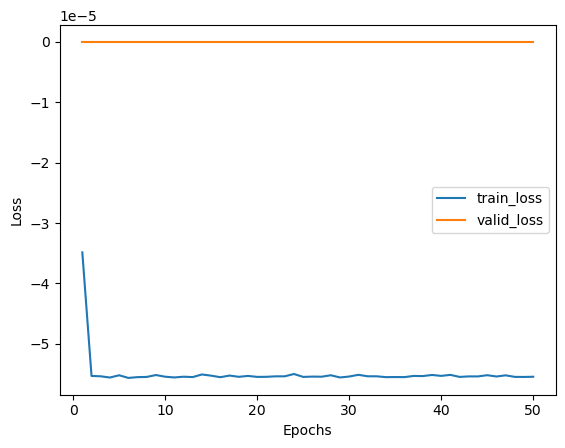

In [97]:
from matplotlib import pyplot as plt
epochs = range(1, len(loss_hist_train) + 1)
plt.plot(epochs, loss_hist_train, label='train_loss')
plt.plot(epochs, loss_hist_valid, label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

number of samples: 4
tensor([[7.2699e-23, 5.6186e-15, 1.1164e-15,  ..., 8.5666e-13, 1.1374e-12,
         4.0588e-14],
        [3.8332e-22, 1.6195e-14, 3.3035e-15,  ..., 2.1453e-12, 2.6699e-12,
         1.1562e-13],
        [7.9278e-23, 5.9517e-15, 1.1417e-15,  ..., 9.7872e-13, 1.2481e-12,
         4.1913e-14],
        ...,
        [7.3963e-21, 1.1825e-13, 2.0812e-14,  ..., 1.3930e-11, 1.2201e-11,
         8.6077e-13],
        [2.4853e-27, 8.5428e-18, 1.8157e-18,  ..., 3.2186e-15, 2.3726e-15,
         1.2602e-16],
        [2.3683e-22, 1.2022e-14, 2.3129e-15,  ..., 1.5300e-12, 2.1485e-12,
         7.9960e-14]])


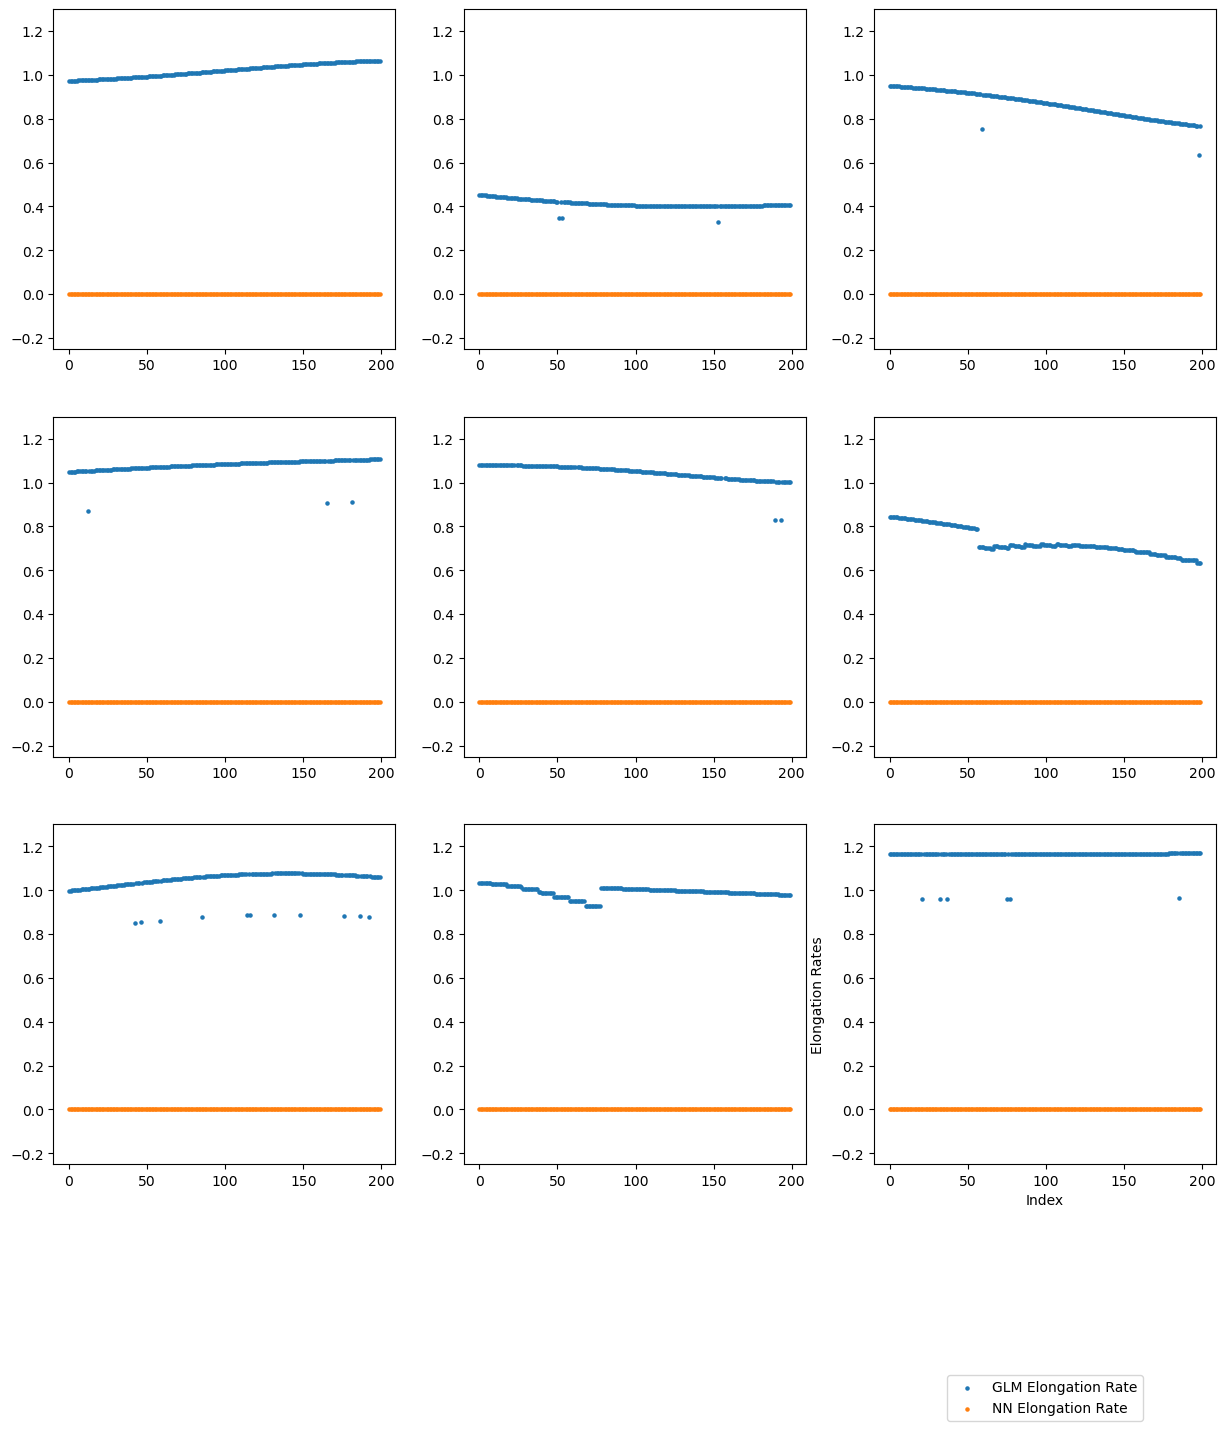

In [100]:
model.eval()

inputs = next(iter(trndl))#tstdl)) 
print("number of samples: " + str(len(inputs)))

with torch.no_grad():
    outputs = model(inputs['Y_ji'])
    
#outputs = torch.exp(outputs)
print(outputs)

targets = inputs['Z_ji']

plot_data(targets, outputs)

#for batch in trndl:
#    targets = inputs['Z_ji']
#    outputs = model(inputs['X_ji'])#'Y_ji'])
#    outputs = torch.exp(outputs)
    
#    plot_data(targets, outputs)